<a href="https://colab.research.google.com/github/gitblankhub/2023-DCC/blob/main/%EB%B3%B8%EC%84%A0%EC%B5%9C%EC%A2%85%EC%A0%9C%EC%B6%9C/Mission3_%EC%A0%9C%EC%B6%9C%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 한글 폰트를 위해 실행 후 런타임 다시 할당
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (51.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and direc

# 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 라이브러리 및 모듈 불러오기
import torch
import numpy as np

import os
from tqdm.notebook import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

from torch.backends import cudnn
cudnn.benchmark = True

import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize

import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import unicodedata

In [ ]:
# GPU 사용 가능여부 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 현재 선택된 디바이스 출력
print(device)

cuda:0


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/DataCreatorCamp

/content/drive/MyDrive/Colab Notebooks/DataCreatorCamp


# 데이터 개수 및 분포 확인

In [ ]:
# kfood_health_train 경로 설정
kfood_health_train = './kfood_health_train'

# 이미지 파일 확장자 리스트
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

# 디렉토리 내의 각 파일에 대해 이미지 파일 개수 확인
for file_name in os.listdir(kfood_health_train):
    file_path = os.path.join(kfood_health_train, file_name)
    if os.path.isdir(file_path):
        image_count = 0
        for entry in os.listdir(file_path):
            entry_path = os.path.join(file_path, entry)
            if os.path.isfile(entry_path) and any(entry.lower().endswith(ext) for ext in image_extensions):
                # 이미지 파일 확장자를 가진 파일을 찾으면 개수를 누적
                image_count += 1
        print(f"파일명: {file_name}, 이미지 개수: {image_count}")

파일명: 갈비찜, 이미지 개수: 1267
파일명: 된장찌개, 이미지 개수: 951
파일명: 김치국, 이미지 개수: 1237
파일명: 떡국, 이미지 개수: 962
파일명: 고등어, 이미지 개수: 1177
파일명: 모듬초밥, 이미지 개수: 1160
파일명: 돼지갈비찜, 이미지 개수: 891
파일명: 낚지볶음, 이미지 개수: 1032
파일명: 가리비, 이미지 개수: 831
파일명: 배추김치, 이미지 개수: 1040
파일명: 오리로스구이, 이미지 개수: 1152
파일명: 부대찌개, 이미지 개수: 1551
파일명: 순대, 이미지 개수: 864


In [ ]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 이미지 파일 확장자 리스트
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]  # 이미지 파일 경로로부터 라벨 추출
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1) # 경로와 라벨 concatenate
    df = df.sample(frac=1, random_state=0).reset_index(drop=True) # index 재설정
    return df

In [ ]:
# 이미지 파일 경로 리스트 생성
image_folder = './kfood_health_train'
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_folder) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]

# 데이터프레임 생성
df = proc_img(image_files)

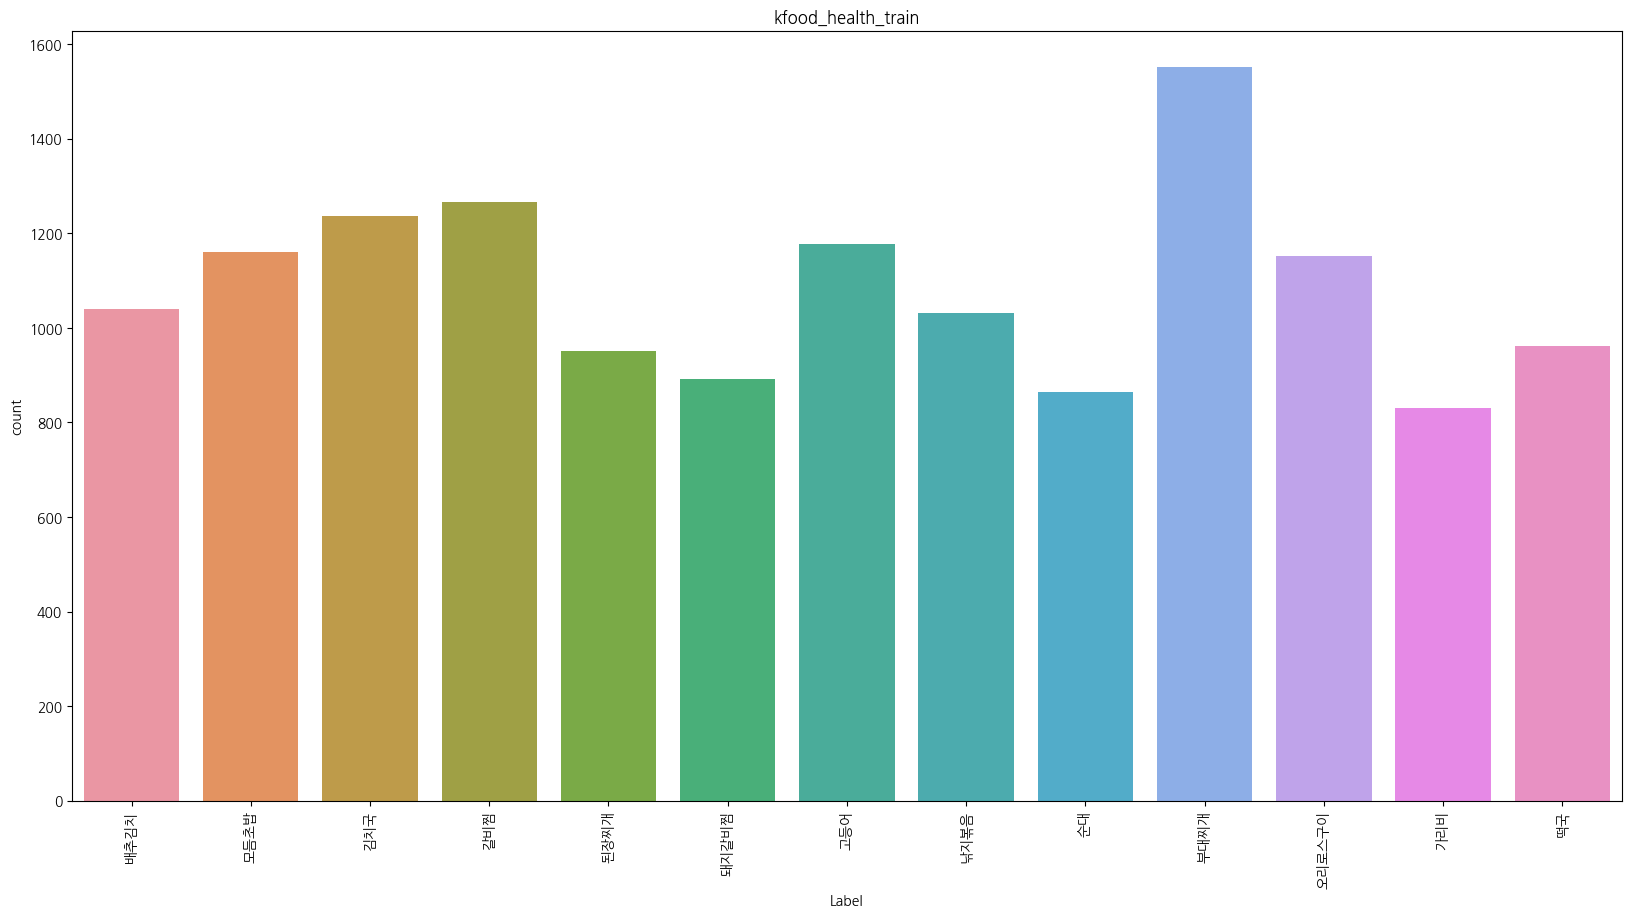

In [ ]:
# 라벨별 카운트 플롯 그리기
plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Label')
plt.xticks(rotation=90)  # x 축 라벨을 90도 회전

# 한글 플롯 레이블에 대한 NFC 정규화
ax = plt.gca()
ax.set_xticklabels([unicodedata.normalize('NFC', label.get_text()) for label in ax.get_xticklabels()])
plt.title('kfood_health_train')

plt.show()

In [ ]:
# kfood_health_val 경로 설정
kfood_health_val = './kfood_health_val'

# 이미지 파일 확장자 리스트
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

# 디렉토리 내의 각 파일에 대해 이미지 파일 개수 확인
for file_name in os.listdir(kfood_health_val):
    file_path = os.path.join(kfood_health_val, file_name)
    if os.path.isdir(file_path):
        image_count = 0
        for entry in os.listdir(file_path):
            entry_path = os.path.join(file_path, entry)
            if os.path.isfile(entry_path) and any(entry.lower().endswith(ext) for ext in image_extensions):
                # 이미지 파일 확장자를 가진 파일을 찾으면 개수를 누적
                image_count += 1
        print(f"파일명: {file_name}, 이미지 개수: {image_count}")

파일명: 된장찌개, 이미지 개수: 109
파일명: 배추김치, 이미지 개수: 128
파일명: 갈비찜, 이미지 개수: 151
파일명: 김치국, 이미지 개수: 165
파일명: 모듬초밥, 이미지 개수: 161
파일명: 고등어, 이미지 개수: 137
파일명: 낚지볶음, 이미지 개수: 122
파일명: 가리비, 이미지 개수: 103
파일명: 떡국, 이미지 개수: 118
파일명: 돼지갈비찜, 이미지 개수: 107
파일명: 오리로스구이, 이미지 개수: 161
파일명: 순대, 이미지 개수: 87
파일명: 부대찌개, 이미지 개수: 215


In [ ]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 이미지 파일 확장자 리스트
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]  # 이미지 파일 경로로부터 라벨 추출
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1) # 경로와 라벨 concatenate
    df = df.sample(frac=1, random_state=0).reset_index(drop=True) # index 재설정
    return df

In [ ]:
# 이미지 파일 경로 리스트 생성
image_folder = './kfood_health_val'
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_folder) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]

# 데이터프레임 생성
df = proc_img(image_files)

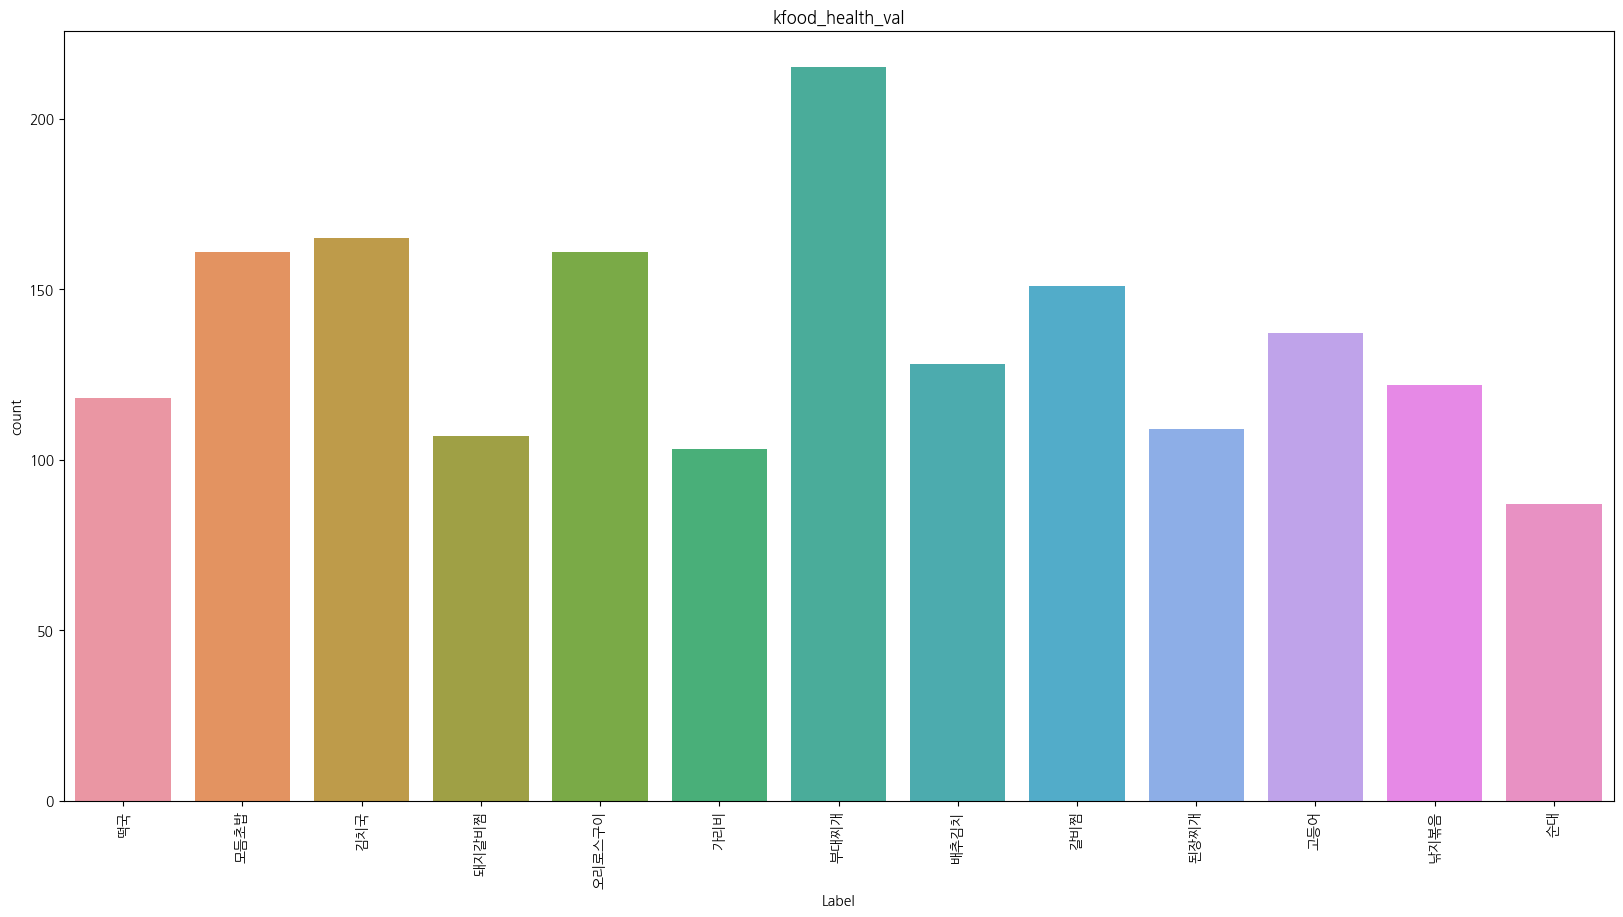

In [ ]:
# 라벨별 카운트 플롯 그리기
plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Label')
plt.xticks(rotation=90)  # x 축 라벨을 90도 회전

# 한글 플롯 레이블에 대한 NFC 정규화
ax = plt.gca()
ax.set_xticklabels([unicodedata.normalize('NFC', label.get_text()) for label in ax.get_xticklabels()])
plt.title('kfood_health_val')

plt.show()

# Mission 3-1

## load data

In [ ]:
# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),           # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.6093853, 0.49013588, 0.3961599), (0.2530398, 0.25769088, 0.26764917))  # 이미지 정규화
])

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.RandomRotation(180),  # 180도 랜덤 회전
    transforms.CenterCrop(220),  # 중앙 자르기
    transforms.ToTensor(),           # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.6093853, 0.49013588, 0.3961599), (0.2530398, 0.25769088, 0.26764917))  # 이미지 정규화
])

# 데이터셋 정의
dataset = ImageFolder(root='./kfood_health_train', transform=transform)
testset = ImageFolder(root='./kfood_health_val', transform=transform)

## cross validation : kfood_health_train을 8:2로 나눠 train과 val로 정의

In [ ]:
torch.manual_seed(1)

# 데이터를 Train과 Validation으로 분리
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader 생성
batch_size = 64

# train_dataset에 transform_train을 적용
train_dataset.dataset.transform = transform_train

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
# 데이터 개수 확인
print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))
print(len(trainloader))
print(len(testloader))

14115
11292
2823
177
28


In [ ]:
classes = dataset.classes
classes

['가리비',
 '갈비찜',
 '고등어',
 '김치국',
 '낚지볶음',
 '돼지갈비찜',
 '된장찌개',
 '떡국',
 '모듬초밥',
 '배추김치',
 '부대찌개',
 '순대',
 '오리로스구이']

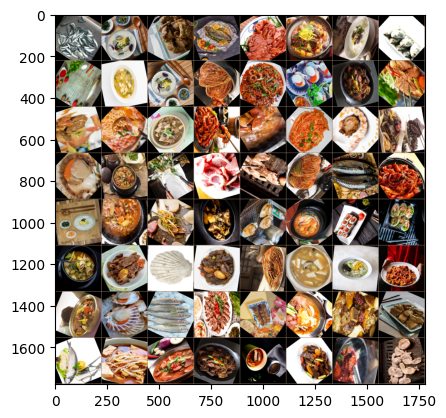

고등어 떡국 돼지갈비찜 고등어 오리로스구이 갈비찜 떡국 고등어 고등어 된장찌개 떡국 배추김치 낚지볶음 가리비 갈비찜 갈비찜 돼지갈비찜 부대찌개 된장찌개 낚지볶음 부대찌개 배추김치 가리비 갈비찜 가리비 된장찌개 오리로스구이 오리로스구이 오리로스구이 배추김치 고등어 낚지볶음 떡국 부대찌개 오리로스구이 돼지갈비찜 가리비 된장찌개 모듬초밥 모듬초밥 된장찌개 갈비찜 가리비 돼지갈비찜 배추김치 된장찌개 떡국 낚지볶음 갈비찜 가리비 고등어 오리로스구이 순대 부대찌개 갈비찜 돼지갈비찜 고등어 김치국 부대찌개 갈비찜 김치국 돼지갈비찜 갈비찜 오리로스구이


In [ ]:
# 클래스 이름 가져오기
classes = dataset.classes
# unnormalize 함수 정의
def unnormalize(img):
    mean = (0.6093853, 0.49013588, 0.3961599)
    std = (0.2530398, 0.25769088, 0.26764917)
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img
# imshow 함수 정의
def imshow(img):
    img = unnormalize(img)  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# label 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## using resnet101 train

In [ ]:
# resnet101 파라미터 무작위로 초기화하여 사용
resnet101 = models.resnet101(pretrained=False).to(device)

# fc layer 수정
resnet101.fc = nn.Linear(resnet101.fc.in_features, len(classes)).to(device)

In [ ]:
state_dict_path='./mission2_1123.pt'
weights = torch.load(state_dict_path)

resnet101.fc = nn.Linear(resnet101.fc.in_features, 42)
# definc model : weights are randomly initiated
resnet101.load_state_dict(weights)

<All keys matched successfully>

In [ ]:
# 기존 분류 레이어의 출력 피처 수 얻기
in_features = resnet101.fc.in_features

# 새로운 분류 레이어 정의 (출력 개수를 13로 변경)
new_classifier = nn.Linear(in_features, len(classes))

# 모델의 분류 레이어를 새로 정의한 레이어로 대체
resnet101.fc = new_classifier

'''
# freezing
for param in resnet101.parameters():
   param.requires_grad = False
# layer3부터 마지막 마지막 레이어까지만 가중치만 학습
for name, param in resnet101.named_parameters():
    if name.startswith('layer3') or name.startswith('layer4') or name.startswith('fc'):
    	param.requires_grad = True
'''

# 모델을 학습 모드로 설정
resnet101.train()

resnet101.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 가중치 확인
for name, param in resnet101.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

conv1.weight: requires_grad=True
bn1.weight: requires_grad=True
bn1.bias: requires_grad=True
layer1.0.conv1.weight: requires_grad=True
layer1.0.bn1.weight: requires_grad=True
layer1.0.bn1.bias: requires_grad=True
layer1.0.conv2.weight: requires_grad=True
layer1.0.bn2.weight: requires_grad=True
layer1.0.bn2.bias: requires_grad=True
layer1.0.conv3.weight: requires_grad=True
layer1.0.bn3.weight: requires_grad=True
layer1.0.bn3.bias: requires_grad=True
layer1.0.downsample.0.weight: requires_grad=True
layer1.0.downsample.1.weight: requires_grad=True
layer1.0.downsample.1.bias: requires_grad=True
layer1.1.conv1.weight: requires_grad=True
layer1.1.bn1.weight: requires_grad=True
layer1.1.bn1.bias: requires_grad=True
layer1.1.conv2.weight: requires_grad=True
layer1.1.bn2.weight: requires_grad=True
layer1.1.bn2.bias: requires_grad=True
layer1.1.conv3.weight: requires_grad=True
layer1.1.bn3.weight: requires_grad=True
layer1.1.bn3.bias: requires_grad=True
layer1.2.conv1.weight: requires_grad=True


In [ ]:
from torchsummary import summary
summary(resnet101, (3,224,224))
# 학습 가능한 파라미터 수

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet101.parameters(), lr=0.0005)

In [ ]:
# 학습 중에 정확도와 손실 기록하기
train_accuracy_list = []
train_loss_list = []
validation_accuracy_list = []
validation_loss_list = []

val_accuracy_max=0
val_loss_min=99999999

In [ ]:
# 학습 길이 50 epoch으로 설정하여 학습
for epoch in range(0, 50):

    # train
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet101(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_acc = 100 * correct_train / total_train

        # print every mini-batchs
        if i % 50 == 49 :
          print(f'[{epoch+1}, {i+1:5d}] train accuracy : {train_acc:.2f}% , train loss : {running_loss/2000:.3f}')
          running_loss = 0.0

    train_accs = 100 * correct_train / total_train
    train_accuracy_list.append(train_accs)
    train_loss_list.append(running_loss)

    # Validation accuracy & loss
    correct_validation = 0
    total_validation = 0
    validation_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for validation
        for i, data in enumerate(valloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = resnet101(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()

    validation_acc = 100 * correct_validation / total_validation
    print(f'epoch {epoch+1}: validation accuracy - {validation_acc:.2f}%, validation loss - {validation_loss/len(valloader):.3f}')

    validation_accuracy_list.append(validation_acc)
    validation_loss_list.append(validation_loss)

    # best model checkpoint에 저장
    if validation_acc > val_accuracy_max:
      val_accuracy_max = validation_acc
      torch.save(resnet101.state_dict(), './mission3_acc_101.pt')
    if validation_loss < val_loss_min:
      val_loss_min = validation_loss
      torch.save(resnet101.state_dict(), './mission3_loss_101.pt')

print('Finished Training')

[1,    50] train accuracy : 58.53% , train loss : 0.034
[1,   100] train accuracy : 71.28% , train loss : 0.012
[1,   150] train accuracy : 76.67% , train loss : 0.009
epoch 1: validation accuracy - 88.38%, validation loss - 0.349
[2,    50] train accuracy : 91.47% , train loss : 0.006
[2,   100] train accuracy : 92.00% , train loss : 0.005
[2,   150] train accuracy : 92.29% , train loss : 0.005
epoch 2: validation accuracy - 92.70%, validation loss - 0.228
[3,    50] train accuracy : 94.44% , train loss : 0.004
[3,   100] train accuracy : 94.48% , train loss : 0.004
[3,   150] train accuracy : 94.62% , train loss : 0.003
epoch 3: validation accuracy - 94.51%, validation loss - 0.180
[4,    50] train accuracy : 96.31% , train loss : 0.003
[4,   100] train accuracy : 96.25% , train loss : 0.003
[4,   150] train accuracy : 96.03% , train loss : 0.003
epoch 4: validation accuracy - 94.72%, validation loss - 0.184
[5,    50] train accuracy : 96.66% , train loss : 0.002
[5,   100] train acc

In [ ]:
PATH = './mission3_101.pt'
torch.save(resnet101.state_dict(),PATH) # 지정한 경로에 학습한 파라미터 저장

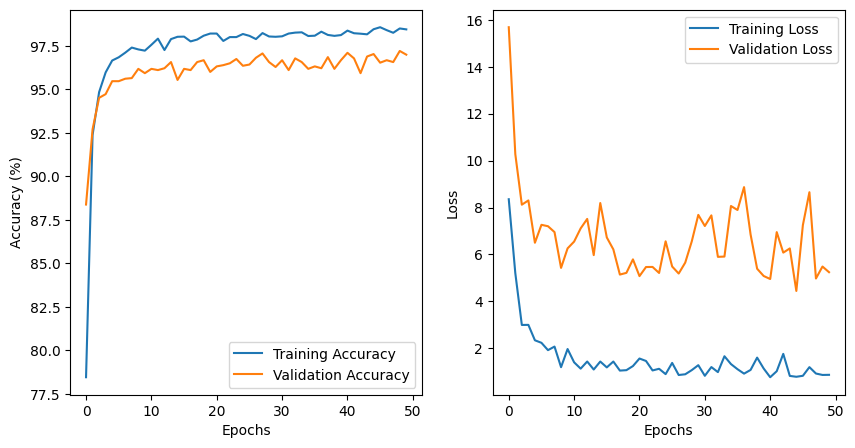

In [ ]:
# 학습 중에 정확도와 손실 기록 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## top1 accuracy

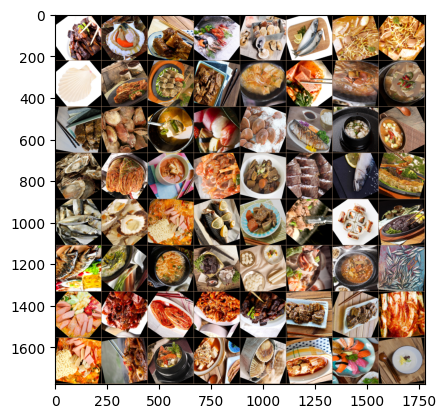

GroundTruth:  돼지갈비찜 가리비 돼지갈비찜 고등어 가리비 고등어 부대찌개 부대찌개 가리비 배추김치 순대 돼지갈비찜 김치국 부대찌개 부대찌개 된장찌개 돼지갈비찜 가리비 된장찌개 모듬초밥 가리비 고등어 된장찌개 된장찌개 가리비 배추김치 김치국 낚지볶음 갈비찜 순대 고등어 순대 고등어 가리비 부대찌개 고등어 돼지갈비찜 오리로스구이 모듬초밥 순대 고등어 떡국 된장찌개 순대 떡국 부대찌개 부대찌개 고등어 부대찌개 낚지볶음 배추김치 낚지볶음 돼지갈비찜 돼지갈비찜 갈비찜 배추김치 부대찌개 낚지볶음 된장찌개 김치국 가리비 김치국 모듬초밥 떡국


In [ ]:
# valloader 이미지, 라벨 가져오기
dataiter = iter(valloader)
images, labels = next(dataiter)

# 클래스 이름 가져오기
classes = dataset.classes

# unnormalize함수 정의
def unnormalize(img):
    mean = (0.6093853, 0.49013588, 0.3961599)
    std = (0.2530398, 0.25769088, 0.26764917)
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

# inshow함수 정의
def imshow(img):
    img = unnormalize(img)  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images , GroundTruth: 실제 이미지 라벨
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# 모델, 이미지 GPU 이동
resnet101 = resnet101.to(device)
images = images.to(device)

# 이미지 입력, 출력 계산
outputs = resnet101(images)

In [ ]:
_, predicted = torch.max(outputs, 1) # 각 class의 확률이 가장 높은 것만 출력

# 예측 label 출력
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

Predicted:  돼지갈비찜 가리비 돼지갈비찜 고등어 가리비 고등어 부대찌개 부대찌개 가리비 배추김치 순대 돼지갈비찜 된장찌개 부대찌개 부대찌개 된장찌개 돼지갈비찜 가리비 된장찌개 모듬초밥 가리비 고등어 된장찌개 된장찌개 가리비 배추김치 김치국 부대찌개 갈비찜 순대 고등어 순대 고등어 가리비 부대찌개 고등어 돼지갈비찜 오리로스구이 모듬초밥 순대 고등어 떡국 된장찌개 순대 떡국 부대찌개 부대찌개 고등어 부대찌개 낚지볶음 배추김치 낚지볶음 돼지갈비찜 돼지갈비찜 갈비찜 배추김치 부대찌개 낚지볶음 된장찌개 김치국 가리비 김치국 모듬초밥 떡국


In [ ]:
# Validation accuracy 출력
val_correct = 0
val_total = 0

with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet101(images)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * val_correct // val_total} %')

Validation Accuracy: 96 %


In [ ]:
#각 클래스 중에서 어떤 클래스를 잘 맞췄는지, 어떤 클래스를 잘 못맞췄는지 확인
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet101(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 가리비 is 94.1 %
Accuracy for class: 갈비찜 is 89.4 %
Accuracy for class: 고등어 is 98.7 %
Accuracy for class: 김치국 is 99.6 %
Accuracy for class: 낚지볶음 is 98.1 %
Accuracy for class: 돼지갈비찜 is 84.3 %
Accuracy for class: 된장찌개 is 98.6 %
Accuracy for class: 떡국 is 100.0 %
Accuracy for class: 모듬초밥 is 97.1 %
Accuracy for class: 배추김치 is 100.0 %
Accuracy for class: 부대찌개 is 99.3 %
Accuracy for class: 순대 is 98.9 %
Accuracy for class: 오리로스구이 is 99.5 %


## validation 채점 : kfood_health_val 데이터 사용해서 정확도 측정

In [ ]:
# 채점시 사용되는 코드
@torch.no_grad()
def validate_epoch(model: nn.Module, data_loader: DataLoader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.concat(accuracies).float().mean() * 100
    return accuracy.item()

In [ ]:
validate_epoch(resnet101,testloader,device)

measuring accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

97.22222137451172

# checkpoint loader

In [ ]:
# 저장했던 mission3.pt 불러오기
PATH = './mission3_loss_101.pt'
resnet101 = models.resnet101(weights=None)
optimizer = optim.Adam(resnet101.parameters(), lr=0.001)

num_classes = 13
resnet101.fc = nn.Linear(resnet101.fc.in_features, num_classes)

checkpoint = torch.load(PATH)
resnet101.load_state_dict(checkpoint)

# 평가모드
resnet101.eval()

resnet101 = resnet101.to(device)

In [ ]:
# 채점시 사용되는 코드
@torch.no_grad()
def validate_epoch(model: nn.Module, data_loader: DataLoader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.concat(accuracies).float().mean() * 100
    return accuracy.item()

In [ ]:
validate_epoch(resnet101,testloader,device)

measuring accuracy:   0%|          | 0/28 [00:00<?, ?it/s]

97.61904907226562